Spark Version

In [1]:
sc.version

'2.4.7-amzn-0'

In [2]:
print(type(sc))

<class 'pyspark.context.SparkContext'>


Impoting Libraries. We had to install sklearn,matplotlib,seaborn libraries other than pyspark by using pip.

In [3]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import math
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import regexp_extract
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error

Load Data from S3 Bucket

In [4]:
train ='s3://nitinnetflix/TrainingRatings.txt'
movie = 's3://nitinnetflix/movie_titles.txt'
test = 's3://nitinnetflix/TestingRatings.txt'

Lets Build the Schema by using pyspark.

In [5]:
trainschema = StructType([StructField('mID', IntegerType()),StructField('uID', IntegerType()),StructField('ratings',DoubleType())])
movieschema = StructType([StructField('mID', IntegerType()),StructField('yearofrelease', IntegerType()),StructField('title', StringType())])
testschema = StructType([StructField('mID', IntegerType()),StructField('uID', IntegerType()),StructField('ratings',DoubleType())])

In [6]:
traindata = sc.textFile(train)

In [7]:
traindata.count() 

3255352

In [8]:
traindata.take(10)

['8,1744889,1.0',
 '8,1395430,2.0',
 '8,1205593,4.0',
 '8,1488844,4.0',
 '8,1447354,1.0',
 '8,306466,4.0',
 '8,1331154,4.0',
 '8,1818178,3.0',
 '8,991725,4.0',
 '8,1987434,4.0']

Load all the data train,test and movie.

In [9]:
movie_df = sqlContext.read.format('txt').options(inferSchema=True).schema(movieschema).csv(movie)
train_df = sqlContext.read.format('txt').options(inferSchema=True).schema(trainschema).csv(train)
test_df = sqlContext.read.format('txt').options(inferSchema=True).schema(testschema).csv(test)

Cache the data

In [10]:
train_df.cache()
movie_df.cache()
test_df.cache()

DataFrame[mID: int, uID: int, ratings: double]

Check whether the data is cached

In [11]:
assert train_df.is_cached
assert test_df.is_cached
assert movie_df.is_cached

In [12]:
train_count = train_df.count()
test_count = test_df.count()
movie_count = movie_df.count()
print ('There are %s training, %s testing and %s movies in the datasets' % (train_count,test_count, movie_count))
print ('Training:')
train_df.show(5)
print ('Testing:')
test_df.show(5)
print ('Movies:')
movie_df.show(5, truncate=False)

There are 3255352 training, 100478 testing and 17770 movies in the datasets
Training:
+---+-------+-------+
|mID|    uID|ratings|
+---+-------+-------+
|  8|1744889|    1.0|
|  8|1395430|    2.0|
|  8|1205593|    4.0|
|  8|1488844|    4.0|
|  8|1447354|    1.0|
+---+-------+-------+
only showing top 5 rows

Testing:
+---+-------+-------+
|mID|    uID|ratings|
+---+-------+-------+
|  8| 573364|    1.0|
|  8|2149668|    3.0|
|  8|1089184|    3.0|
|  8|2465894|    3.0|
|  8| 534508|    1.0|
+---+-------+-------+
only showing top 5 rows

Movies:
+---+-------------+----------------------------+
|mID|yearofrelease|title                       |
+---+-------------+----------------------------+
|1  |2003         |Dinosaur Planet             |
|2  |2004         |Isle of Man TT 2004 Review  |
|3  |1997         |Character                   |
|4  |1994         |Paula Abdul's Get Up & Dance|
|5  |2004         |The Rise and Fall of ECW    |
+---+-------------+----------------------------+
only showi

Find out the distinct movies and users in the train and test set

In [13]:
train_df.select('mID').distinct().count()

1821

In [14]:
train_df.select('uID').distinct().count()

28978

In [15]:
test_df.select('mID').distinct().count()

1701

In [16]:
test_df.select('uID').distinct().count()

27555

Convert to a Pandas Dataframe.

In [17]:
train_pandas = train_df.toPandas()
test_pandas = test_df.toPandas()

In [18]:
train_pandas.head()

,mID,uID,ratings
0,8,1744889,1.0
1,8,1395430,2.0
2,8,1205593,4.0
3,8,1488844,4.0
4,8,1447354,1.0


In [19]:
test_pandas.head()

,mID,uID,ratings
0,8,573364,1.0
1,8,2149668,3.0
2,8,1089184,3.0
3,8,2465894,3.0
4,8,534508,1.0


In [20]:
len(train_pandas)

3255352

In [21]:
len(test_pandas)

100478

Find the overall rating for movies and users in train dataset.

In [22]:
movie_rating_mean = pd.DataFrame(train_pandas.groupby('mID')['ratings'].mean())
movie_rating_mean['counts'] =pd.DataFrame(train_pandas.groupby('mID')['ratings'].count())
movie_rating_mean.head()

,ratings,counts
mID,,
8,3.055104,2831
28,3.760127,12244
43,2.310345,58
48,3.620648,1666
61,2.385965,57


In [23]:
user_rating_mean = pd.DataFrame(train_pandas.groupby('uID')['ratings'].mean())
user_rating_mean['counts'] =pd.DataFrame(train_pandas.groupby('uID')['ratings'].count())
user_rating_mean.head()

,ratings,counts
uID,,
7,3.903846,104
79,3.630952,84
199,3.943662,71
481,4.351351,74
769,3.193878,98


Visualize each users rating count in training set.

<AxesSubplot:>

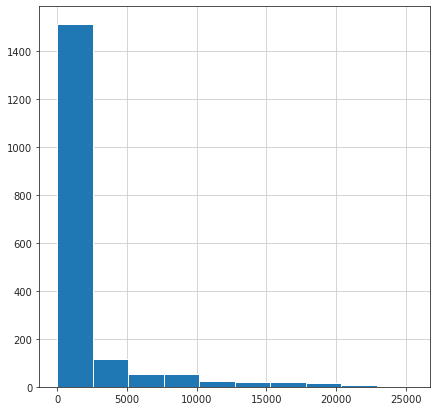

In [24]:
sns.set_style('ticks')
plt.figure(figsize=(7,7))
movie_rating_mean['counts'].hist(bins=10)

<AxesSubplot:xlabel='uID'>

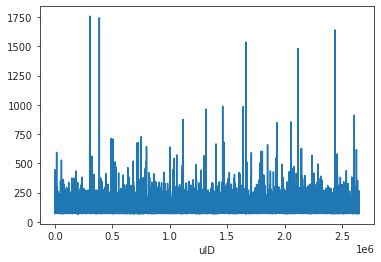

In [25]:
train_pandas.groupby('uID')['mID'].count().plot()

Find the overall rating for movies and users in test dataset.

In [26]:
movie_rating_mean_test = pd.DataFrame(test_pandas.groupby('mID')['ratings'].mean())
movie_rating_mean_test['counts'] =pd.DataFrame(test_pandas.groupby('mID')['ratings'].count())
movie_rating_mean_test.tail()

,ratings,counts
mID,,
17725,3.211538,52
17728,4.500000,2
17734,3.000000,1
17741,2.968750,32
17742,3.125000,8


In [27]:
#checking overall average rate of the user with their counts  in the training set
user_rating_mean_test = pd.DataFrame(test_pandas.groupby('uID')['ratings'].mean())
user_rating_mean_test['counts'] =pd.DataFrame(test_pandas.groupby('uID')['ratings'].count())
user_rating_mean_test.tail()

,ratings,counts
uID,,
2648869,2.777778,9
2648885,4.000000,5
2649120,5.000000,2
2649267,4.142857,7
2649285,2.333333,3


Visualize each users rating count.

<AxesSubplot:>

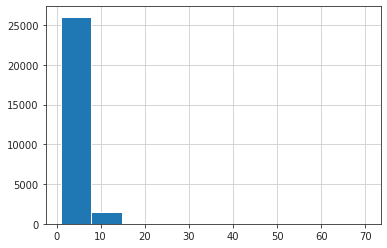

In [28]:
sns.set_style('ticks')
user_rating_mean_test['counts'].hist(bins=10)

In [29]:
test_pandas.groupby('uID')['ratings'].count().sort_values(ascending=False).head()

uID
1664010    70
2439493    52
305344     52
387418     51
1314869    38
Name: ratings, dtype: int64

In [30]:
test_pandas.groupby('mID')['ratings'].count().sort_values(ascending=False).head()

mID
6971    811
4640    756
6287    737
9728    706
8915    695
Name: ratings, dtype: int64

<AxesSubplot:>

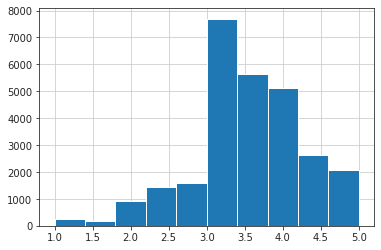

In [31]:
user_rating_mean_test['ratings'].hist(bins=10)

# Problem 1


Now that the preprocessing is over and we have viewed the way our data is displaced lets start by building a collaborative filtering using ALS.

Because we would still like to know the best parameters for the ALS model, we will be alternating mainly the rank and the maxiter parameters. We will split our training further to help us iron out these best paramaters

we will be using the coldstrategy to drop nans

In [32]:
training, testing= train_df.randomSplit([0.8, 0.2])
als = ALS(maxIter=5, regParam=0.01, userCol="uID", itemCol="mID", ratingCol="ratings",coldStartStrategy="drop")
model = als.fit(training)

In [33]:
predictions = model.transform(testing)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="ratings",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8680544505219475


Hyper Paramater tuning

In [34]:
ranks = [6,8,10,12,14]
for i in range(len(ranks)):
    print(i)
    als = ALS(maxIter=10,rank=ranks[i], regParam=0.01, userCol="uID", itemCol="mID", ratingCol="ratings",coldStartStrategy="drop")
    model = als.fit(training)
    predictions = model.transform(testing)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="ratings",predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    print("Root-mean-square error = " + str(rmse))
    predictions.show()

0
Root-mean-square error = 0.8551009473555408
+---+-------+-------+----------+
|mID|    uID|ratings|prediction|
+---+-------+-------+----------+
|  8|1497891|    4.0| 3.3741612|
|  8|2358799|    1.0|  3.601194|
|  8|2531111|    1.0|  2.945887|
| 28| 446160|    3.0| 3.6510394|
| 28| 953170|    4.0| 4.2567377|
| 28|1742759|    3.0| 3.1972098|
| 28|2250628|    2.0| 3.2950711|
| 48|1909175|    4.0| 3.6673388|
|111|1629521|    2.0| 2.1819172|
|122|1628484|    2.0| 2.6963592|
|127| 128389|    5.0| 2.6734257|
|156|2629660|    2.0|  2.729957|
|409|1742759|    2.0| 2.8589942|
|442| 446160|    4.0| 3.9623058|
|442|1434507|    5.0| 5.0844507|
|442|1742759|    5.0| 3.3469996|
|443|1896167|    4.0| 3.8345618|
|518|1434507|    5.0|  4.771213|
|606|1742759|    4.0| 2.6732342|
|626|1497891|    4.0| 3.0413392|
+---+-------+-------+----------+
only showing top 20 rows

1
Root-mean-square error = 0.8545109693467581
+---+-------+-------+----------+
|mID|    uID|ratings|prediction|
+---+-------+-------+---

For our models built, the paramaters rank of 8 and maxiter of 10 seemed to be our best model. Lets varify the regparams for this same model and see if that decreases our root mean square error.

In [35]:
als = ALS(maxIter=10,rank=8, regParam=0.09, userCol="uID", itemCol="mID", ratingCol="ratings",coldStartStrategy="drop")
model = als.fit(training)
predictions = model.transform(testing)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="ratings",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))
predictions.show()

Root-mean-square error = 0.852040422384116
+---+-------+-------+----------+
|mID|    uID|ratings|prediction|
+---+-------+-------+----------+
|  8|1497891|    4.0|  2.611914|
|  8|2358799|    1.0|  3.055101|
|  8|2531111|    1.0| 2.9374247|
| 28| 446160|    3.0| 3.7499733|
| 28| 953170|    4.0| 4.1837726|
| 28|1742759|    3.0| 3.2339163|
| 28|2250628|    2.0| 3.1929152|
| 48|1909175|    4.0| 3.7260492|
|111|1629521|    2.0| 2.2248561|
|122|1628484|    2.0| 2.7162952|
|127| 128389|    5.0|  2.542643|
|156|2629660|    2.0| 2.7356007|
|409|1742759|    2.0| 2.9578366|
|442| 446160|    4.0|  3.961347|
|442|1434507|    5.0| 5.0880876|
|442|1742759|    5.0| 3.3351014|
|443|1896167|    4.0| 3.7508047|
|518|1434507|    5.0|  4.795288|
|606|1742759|    4.0| 2.8785424|
|626|1497891|    4.0| 3.3087177|
+---+-------+-------+----------+
only showing top 20 rows



Well that seems to be our best model yet.

# Problem 2

We will analyze our data and find the average rating of movie given all users who rated the movie- average overlap of users for items
 
We will also find the average rating given by users - average of items for users

In [36]:
def get_average(user):
    summed =0
    count =0

    for i in range(len(user)):
        if(user[i]==0):
            summed = summed +0
        else:
            summed= user[i] +summed
            count= 1+ count
    avgg=summed/count
    return avgg

Find the unique users and movies in our dataframe

In [37]:
len(test_pandas['uID'].unique())

27555

In [38]:
len(test_pandas['mID'].unique())

1701

Create a new dataframe with userID as index and the movieId as columns for our training data

In [39]:
user_movie_rating = train_pandas.pivot_table(index='uID', columns='mID', values='ratings')
user_movie_rating.tail()

mID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
2648869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
2648885,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649285,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will use the random five movies and users with the most count from our test data.
Movies with IDs:6971,4640,6287,9728,8915
Users with the IDs:1664010,2439493,305344,387418,1314869

In [40]:
user_movie_rating[6971]

uID
7          4.0
79         5.0
199        4.0
481        4.0
769        4.0
          ... 
2648869    4.0
2648885    5.0
2649120    5.0
2649267    3.0
2649285    5.0
Name: 6971, Length: 28978, dtype: float64

Fill the nan values with 0.

In [41]:
user_movie_rating.fillna(0, inplace= True)
user_movie_rating.head()

mID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
user_movie_rating[8915]

uID
7          0.0
79         0.0
199        4.0
481        0.0
769        3.0
          ... 
2648869    4.0
2648885    4.0
2649120    4.0
2649267    0.0
2649285    3.0
Name: 8915, Length: 28978, dtype: float64

In [43]:
user1664010= list(user_movie_rating.loc[1664010])
avg1664010= get_average(user1664010)
print(avg1664010)

4.2384364820846905


In [44]:
user2439493= list(user_movie_rating.loc[2439493])
avg2439493= get_average(user2439493)
print(avg2439493)

1.225609756097561


In [45]:
user305344= list(user_movie_rating.loc[305344])
avg305344= get_average(user305344)
print(avg305344)

1.904382470119522


In [46]:
user387418= list(user_movie_rating.loc[387418])
avg387418= get_average(user387418)
print(avg387418)

1.8405963302752293


In [47]:
user1314869= list(user_movie_rating.loc[1314869])
avg1314869= get_average(user1314869)
print(avg1314869)

2.970984455958549


In [48]:
estimate_item_user =avg1314869+avg387418+avg305344+avg2439493+avg1664010
print(estimate_item_user/5)

2.4360018989071106


The estimate_item_user gives the overlap of item rated by  our 5 selected users

Create a new dataframe with userID as index and the movieId as columns for our training data

In [49]:
movie_user_rating = train_pandas.pivot_table(index='mID', columns='uID', values='ratings')
movie_user_rating.head()

uID,7,79,199,481,769,906,1310,1333,1427,1442,...,2648572,2648589,2648730,2648734,2648853,2648869,2648885,2649120,2649267,2649285
mID,,,,,,,,,,,,,,,,,,,,,
8,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,4.0,NaN,NaN,NaN,NaN,3.0,3.0,2.0,NaN,4.0,...,NaN,3.0,4.0,NaN,2.0,NaN,4.0,NaN,NaN,4.0
43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
movie_user_rating.fillna(0, inplace= True)
movie_user_rating.head()

uID,7,79,199,481,769,906,1310,1333,1427,1442,...,2648572,2648589,2648730,2648734,2648853,2648869,2648885,2649120,2649267,2649285
mID,,,,,,,,,,,,,,,,,,,,,
8,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,4.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,4.0,...,0.0,3.0,4.0,0.0,2.0,0.0,4.0,0.0,0.0,4.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
movie6971= list(movie_user_rating.loc[6971])
avg6971= get_average(movie6971)
print(avg6971)

4.071815611748076


In [52]:
movie4640= list(movie_user_rating.loc[4640])
avg4640= get_average(movie4640)
print(avg4640)

4.047438894792774


In [53]:
movie6287= list(movie_user_rating.loc[6287])
avg6287= get_average(movie6287)
print(avg6287)

3.7261099495756977


In [54]:
movie9728= list(movie_user_rating.loc[9728])
avg9728= get_average(movie9728)
print(avg6971)

4.071815611748076


In [55]:
movie8915= list(movie_user_rating.loc[8915])
avg8915= get_average(movie8915)
print(avg8915)

3.9663373050469826


In [56]:
estimate_user_item=avg8915+avg6971+avg6287+avg4640+avg6971
print(estimate_user_item/5)

3.976703474582321


The estimate_user_item gives the overlap of users that rated items rated by  our 5 selected users

# My Take on the Averages


As expected the overlap of users that rated items is higher than the overlap of items rated by users. This is because, more often than not a users rate on an item is influenced mostly by personal preference. ie, a user that likes the cartoons is likely to rate the movie Tom and Jerry relatively high. Likewise in the inverse, a user that hates cartoons is likely to rate the cartoon with a lower rate. the average overall for both is these users is like to be fairly even, However, the overlap of items rated by users will have a combination of very high and very low rates and this is likely to result in an overall high average

# Part 2 section B --The Selection

	I selected the Matrix factorization approach using SVD simply because of its ability to scale across the large data. 
	The similarity measure- the user-user or item-item matrix for our dataset with more than 1000 distinct users would require a lot of computation and memory. This approach considering the size of our data would not be the best option.


I will be normalizing my dataset because, not only does our testing data contains several nans as a result of not being rated, but also, every time a new user is entered, without any prior rated information, without normalizing the model most likely cannot predict any movie to this new user.

	Finally, my SVD approach is because this approach allows for the dataset to be scaled and appropriately reduces the large dimensions to a smaller set that is easily scalable through

Create a normalized dataframe from our training set

In [57]:
normalised_mat =  user_movie_rating - np.asarray([(np.mean(user_movie_rating, 1))]).T
normalised_mat.head()

mID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,4.777046,3.777046,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,...,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954,-0.222954
79,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,...,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490,-0.167490
199,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,3.846238,...,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762,-0.153762
481,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,4.823174,...,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826,-0.176826
769,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,...,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884,-0.171884


# Problem 3: The SVD Approach

Split the training set

In [58]:
trainPandas, testPandas = train_test_split(train_pandas, test_size=0.6, random_state=0)

In [59]:
trainPandas.head()

,mID,uID,ratings
1177823,6066,1807643,1.0
2607747,14144,1859991,3.0
2982630,16082,522637,1.0
1016119,5069,66187,4.0
1715563,9481,920098,3.0


In [60]:
trainp = trainPandas.pivot_table(index='uID', columns='mID', values='ratings')
trainp.fillna(0, inplace= True)
trainp.head()

mID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
testp = testPandas.pivot_table(index='uID', columns='mID', values='ratings')
testp.fillna(0, inplace= True)
testp.head()

mID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
trained = trainp.to_numpy()
user_ratings_mean = np.mean(trained, axis = 1)
trained_demean = trained - user_ratings_mean.reshape(-1, 1)

In [63]:
U, sigma, Vt = svds(trained_demean, k = 50)

In [64]:
sigma = np.diag(sigma)

In [65]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [66]:
print(user_ratings_mean)

[0.08241758 0.05879121 0.06428571 ... 0.05274725 0.04505495 0.07197802]


In [67]:
print((all_user_predicted_ratings[0]))

[ 0.0341765   0.74924155 -0.00162638 ... -0.00334478 -0.0166587
 -0.00939068]


In [68]:
pred_df = pd.DataFrame(all_user_predicted_ratings, columns = trainp.columns, index= trainp.index)
pred_df.head()

mID,8,28,43,48,61,64,66,92,96,111,...,17654,17660,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,0.034177,0.749242,-0.001626,-0.018925,-0.002373,-0.007050,-0.003369,-0.003599,-0.000042,0.412604,...,0.259888,-0.004119,-0.001759,0.147066,-0.019570,0.051315,-0.001293,-0.003345,-0.016659,-0.009391
79,0.004857,0.812900,0.016973,0.071726,0.013448,0.012980,0.014458,0.015650,0.008345,0.334227,...,0.178450,0.013557,0.009924,0.112814,0.016820,-0.041928,0.008691,0.009435,-0.007656,0.014185
199,0.196017,-0.662838,-0.008799,0.016020,-0.008925,-0.005025,-0.006814,0.001732,-0.001292,0.416214,...,0.008295,-0.014459,-0.006628,-0.041134,-0.004697,0.160741,-0.007396,-0.005472,0.063112,-0.028048
481,0.060348,1.181981,-0.002816,0.046674,-0.000397,-0.001576,-0.006943,0.004081,-0.011065,0.835635,...,0.224740,-0.004276,-0.003616,0.166618,0.002012,-0.021220,-0.004803,-0.007340,0.087379,0.004079
769,0.142250,0.348481,0.006319,0.077472,0.011265,0.008808,0.003678,0.007945,-0.005922,0.117017,...,0.002384,0.008751,0.010659,-0.025700,0.021211,0.139224,0.007100,0.005796,0.028668,0.003243


In [69]:
pred_df.loc[79]

mID
8        0.004857
28       0.812900
43       0.016973
48       0.071726
61       0.013448
           ...   
17725   -0.041928
17728    0.008691
17734    0.009435
17741   -0.007656
17742    0.014185
Name: 79, Length: 1820, dtype: float64

In [70]:
movie_pandas = movie_df.toPandas()
movie_pandas.head()

,mID,yearofrelease,title
0,1.0,2003.0,Dinosaur Planet
1,2.0,2004.0,Isle of Man TT 2004 Review
2,3.0,1997.0,Character
3,4.0,1994.0,Paula Abdul's Get Up & Dance
4,5.0,2004.0,The Rise and Fall of ECW


In [71]:
def recommend_movies(predictions_df, userID, movie_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.loc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.uID == (userID)]
    user_full = (user_data.merge(movie_df, how = 'left', left_on = 'mID', right_on = 'mID').
                     sort_values(['ratings'], ascending=False)
                 )

    print ('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print ('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movie_df[~movie_df['mID'].isin(user_full['mID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',left_on = 'mID',right_on = 'mID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1])
    return user_full, recommendations


In [72]:
train_pandas

,mID,uID,ratings
0,8,1744889,1.0
1,8,1395430,2.0
2,8,1205593,4.0
3,8,1488844,4.0
4,8,1447354,1.0
...,...,...,...
3255347,17742,46222,3.0
3255348,17742,2534701,1.0
3255349,17742,208724,3.0
3255350,17742,483107,2.0


In [73]:
already_rated, predictions = recommend_movies(pred_df, 738747, movie_pandas, train_pandas, 10)

User 738747 has already rated 125 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [74]:
already_rated.head(10)

,mID,uID,ratings,yearofrelease,title
104,14484,738747,5.0,1988.0,The Naked Gun
117,16286,738747,5.0,2002.0,Red Dragon
31,3290,738747,5.0,1974.0,The Godfather
54,6971,738747,5.0,1986.0,Ferris Bueller's Day Off
110,15557,738747,5.0,1999.0,Futurama: Vol. 3
24,3084,738747,5.0,1975.0,Rollerball
23,2861,738747,5.0,1996.0,Babylon 5: Season 4
61,8915,738747,5.0,1991.0,Terminator 2: Extreme Edition
43,5656,738747,5.0,1986.0,Star Trek IV: The Voyage Home
19,2532,738747,5.0,1999.0,Futurama: Vol. 1


In [75]:
predictions

,mID,yearofrelease,title
5714,5760.0,2001.0,The Sopranos: Season 3
3602,3638.0,2003.0,Bad Boys II
8789,8851.0,1998.0,Rounders
7089,7145.0,1984.0,Star Trek III: The Search for Spock
11756,11837.0,1987.0,Three Men and a Baby
11533,11613.0,1974.0,The Man with the Golden Gun
438,442.0,1988.0,Mississippi Burning
14099,14198.0,1996.0,Trainspotting: Collector's Edition
846,851.0,1990.0,Back to the Future Part III
3242,3274.0,1998.0,Half Baked


The absolute mean squared error for our training set.

In [76]:
math.sqrt(mean_squared_error(all_user_predicted_ratings,trained_demean))

0.44889265941023837

Lets try predicting first for our smaller test set.

In [77]:
tested = testp.to_numpy()
user_ratings_mean_test = np.mean(tested, axis = 1)
tested_demean = tested - user_ratings_mean_test.reshape(-1, 1)

In [78]:
U, sigma, Vt = svds(tested_demean, k = 50)

In [79]:
sigma = np.diag(sigma)

In [80]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean_test.reshape(-1, 1)

In [81]:
math.sqrt(mean_squared_error(all_user_predicted_ratings,tested_demean))

0.5307017722376988

Lets test our test set. Create a new dataframe with userID as index and the movieId as columns for our testing data.

In [82]:
usertest_movie_rating = test_pandas.pivot_table(index='uID', columns='mID', values='ratings')
usertest_movie_rating.fillna(0, inplace= True)
usertest_movie_rating.head()

mID,8,28,43,48,61,64,66,92,96,111,...,17653,17654,17689,17693,17706,17725,17728,17734,17741,17742
uID,,,,,,,,,,,,,,,,,,,,,
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
finaltest = usertest_movie_rating.to_numpy()
fusertest_ratings_mean = np.mean(finaltest, axis = 1)
ftest_demean = finaltest - fusertest_ratings_mean.reshape(-1, 1)

In [84]:
U, sigma, Vt = svds(ftest_demean, k = 50)
sigma = np.diag(sigma)
final_all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + fusertest_ratings_mean.reshape(-1, 1)

Evaluate the approach for our overall testing data.

In [85]:
math.sqrt(mean_squared_error(final_all_user_predicted_ratings,ftest_demean))

0.1384366719810287

In [86]:
mean_absolute_error(ftest_demean,final_all_user_predicted_ratings)

0.019038633968441944

Our model seems to be performing  very well. Lets go ahead and add me as a new user

We will assume the id of 0000

In [87]:
me = {'uID':0,'mID': 8, 'ratings': 5.0}
me1 = {'uID':0,'mID': 61, 'ratings': 4.0}
me2 = {'uID':0,'mID': 66, 'ratings': 3.0}
me3 = {'uID':0,'mID': 96, 'ratings': 2.0}
me4 = {'uID':0,'mID': 111, 'ratings': 5.0}
me5 = {'uID':0,'mID': 17734}
me6 = {'uID':0,'mID': 17742}

In [88]:
testingPandas=test_pandas.append(me, ignore_index=True )
testingPandas=testingPandas.append(me1, ignore_index=True )
testingPandas=testingPandas.append(me2, ignore_index=True )
testingPandas=testingPandas.append(me3, ignore_index=True )
testingPandas=testingPandas.append(me4, ignore_index=True )
testingPandas=testingPandas.append(me5, ignore_index=True )
testingPandas=testingPandas.append(me6, ignore_index=True )

In [89]:
testingPandas['uID']==0

0         False
1         False
2         False
3         False
4         False
          ...  
100480     True
100481     True
100482     True
100483     True
100484     True
Name: uID, Length: 100485, dtype: bool

In [90]:
testingPandas.pivot_table(index='uID', columns='mID', values='ratings')

mID,8.0,28.0,43.0,48.0,61.0,64.0,66.0,92.0,96.0,111.0,...,17653.0,17654.0,17689.0,17693.0,17706.0,17725.0,17728.0,17734.0,17741.0,17742.0
uID,,,,,,,,,,,,,,,,,,,,,
0.0,5.0,NaN,NaN,NaN,4.0,NaN,3.0,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648869.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2648885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
userTest_movie_rating2 = testingPandas.pivot_table(index='uID', columns='mID', values='ratings')
userTest_movie_rating2.fillna(0, inplace= True)
userTest_movie_rating2.head()

mID,8.0,28.0,43.0,48.0,61.0,64.0,66.0,92.0,96.0,111.0,...,17653.0,17654.0,17689.0,17693.0,17706.0,17725.0,17728.0,17734.0,17741.0,17742.0
uID,,,,,,,,,,,,,,,,,,,,,
0.0,5.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
481.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
finaltest2 = userTest_movie_rating2.to_numpy()
fusertest_ratings_mean2 = np.mean(finaltest2, axis = 1)
ftest_demean2 = finaltest2 - fusertest_ratings_mean2.reshape(-1, 1)

In [93]:
U, sigma, Vt = svds(ftest_demean2, k = 50)
sigma = np.diag(sigma)
final_all_user_predicted_ratings2 = np.dot(np.dot(U, sigma), Vt) + fusertest_ratings_mean2.reshape(-1, 1)

In [94]:
print(fusertest_ratings_mean2)

[0.0111699  0.00587889 0.00940623 ... 0.00587889 0.01704879 0.00411523]


In [96]:
Final_preds_df = pd.DataFrame(final_all_user_predicted_ratings2, columns = userTest_movie_rating2.columns, index= userTest_movie_rating2.index)
Final_preds_df.head()

mID,8.0,28.0,43.0,48.0,61.0,64.0,66.0,92.0,96.0,111.0,...,17653.0,17654.0,17689.0,17693.0,17706.0,17725.0,17728.0,17734.0,17741.0,17742.0
uID,,,,,,,,,,,,,,,,,,,,,
0.0,0.013435,0.016709,0.010729,0.010978,0.010797,0.010710,0.010736,0.010665,0.010859,0.021378,...,0.011138,0.011138,0.010719,0.011439,0.010564,0.010309,0.010713,0.010789,0.011082,0.010808
7.0,0.005978,-0.011882,0.000783,0.003766,0.001285,0.000917,0.000910,0.000924,0.001241,0.018187,...,0.000863,0.001310,0.000979,0.003471,0.001013,0.003236,0.000831,0.000700,0.001178,0.000567
79.0,0.032720,0.047197,0.002523,0.007965,0.002047,0.002346,0.002259,0.002268,0.002354,0.048873,...,0.010302,0.017878,0.002105,-0.001354,0.000954,0.008027,0.002413,0.002274,0.001725,0.002174
199.0,0.008252,0.176598,-0.000783,0.008279,-0.000363,-0.000965,-0.000503,-0.000624,-0.000819,0.019137,...,0.005345,-0.000493,-0.000060,0.007585,0.000285,0.001599,-0.000510,-0.000939,0.000857,-0.001075
481.0,-0.005180,-0.031720,-0.000501,0.003127,-0.000860,-0.000614,-0.000645,-0.000776,-0.001092,0.019732,...,-0.003806,0.016700,-0.000798,0.008671,-0.001856,0.013064,-0.000692,-0.000759,-0.001832,0.003681


Predictions based on my normalized previous rating seems fair though rather low.

Lets try some predictions.

In [98]:
already_rated, predictions = recommend_movies(Final_preds_df, 0, movie_pandas, testingPandas, 10)

User 0 has already rated 7 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [99]:
already_rated.head()

,mID,uID,ratings,yearofrelease,title
0,8.0,0.0,5.0,2004.0,What the #$*! Do We Know!?
4,111.0,0.0,5.0,2003.0,Duplex (Widescreen)
1,61.0,0.0,4.0,1999.0,Ricky Martin: One Night Only
2,66.0,0.0,3.0,1989.0,Barbarian Queen 2
3,96.0,0.0,2.0,2000.0,Inside the Space Station


In [100]:
predictions.head()

,mID,yearofrelease,title
16076,16082.0,2004.0,13 Going on 30
16701,16707.0,2003.0,Old School
16280,16286.0,2002.0,Red Dragon
2907,2913.0,2004.0,Finding Neverland
11831,11837.0,1987.0,Three Men and a Baby
